# Parametric Heteroscedastic Model

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/AbstractGPs.jl/blob/master/examples/3-parametric-heteroscedastic/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/3-parametric-heteroscedastic/).*

This example is a small extension of the standard GP regression problem, in which the
observation noise variance is a function of the input.
It is assumed to be a simple quadratic form, with a single unknown
scaling parameter, in addition to the usual lengthscale and variance parameters
of the GP.
A point estimate of all parameters is obtained using type-II maximum likelihood,
as per usual.

In [1]:
using AbstractGPs
using AbstractGPsMakie
using CairoMakie
using KernelFunctions
using Optim
using ParameterHandling
using Zygote

using LinearAlgebra
using Random
Random.seed!(42)  # setting the seed for reproducibility of this notebook

Random.TaskLocalRNG()

In this example we work with a simple GP with a Gaussian kernel and heteroscedastic observation variance.

In [2]:
observation_variance(θ, x::AbstractVector{<:Real}) = Diagonal(0.01 .+ θ.σ² .* x .^ 2)
function build_gpx(θ, x::AbstractVector{<:Real})
    Σ = observation_variance(θ, x)
    return GP(0, θ.s * with_lengthscale(SEKernel(), θ.l))(x, Σ)
end;

We specify the following hyperparameters:

In [3]:
const flat_θ, unflatten = ParameterHandling.value_flatten((
    s=positive(1.0), l=positive(3.0), σ²=positive(0.1)
));
θ = unflatten(flat_θ);

We generate some observations:

In [4]:
const x = 0.0:0.1:10.0
const y = rand(build_gpx(θ, x));

We specify the objective function:

In [5]:
function objective(flat_θ)
    θ = unflatten(flat_θ)
    fx = build_gpx(θ, x)
    return -logpdf(fx, y)
end;

We use L-BFGS for optimising the objective function.
It is a first-order method and hence requires computing the gradient of the objective function.
We do not derive and implement the gradient function manually here but instead use reverse-mode automatic differentiation with Zygote.
When computing gradients with Zygote, the objective function is evaluated as well.
We can exploit this and [avoid re-evaluating the objective function](https://julianlsolvers.github.io/Optim.jl/stable/#user/tipsandtricks/#avoid-repeating-computations) in such cases.

In [6]:
function objective_and_gradient(F, G, flat_θ)
    if G !== nothing
        val_grad = Zygote.withgradient(objective, flat_θ)
        copyto!(G, only(val_grad.grad))
        if F !== nothing
            return val_grad.val
        end
    end
    if F !== nothing
        return objective(flat_θ)
    end
    return nothing
end;

We optimise the hyperparameters using initializations close to the values that the observations were generated with.

In [7]:
flat_θ_init = flat_θ + 0.01 * randn(length(flat_θ))
result = optimize(
    Optim.only_fg!(objective_and_gradient),
    flat_θ_init,
    LBFGS(;
        alphaguess=Optim.LineSearches.InitialStatic(; scaled=true),
        linesearch=Optim.LineSearches.BackTracking(),
    ),
    Optim.Options(; show_every=100),
)

 * Status: success

 * Candidate solution
    Final objective value:     1.576205e+02

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.97e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.58e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.34e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    13
    ∇f(x) calls:   11


The optimal model parameters are:

In [8]:
θ_final = unflatten(result.minimizer)

(s = 0.385143986830958, l = 2.3342748073768, σ² = 0.08082582089918736)

We compute the posterior GP with these optimal model parameters:

In [9]:
fx_final = build_gpx(θ_final, x)
f_post = posterior(fx_final, y);

We visualize the results with [AbstractGPsMakie](https://github.com/JuliaGaussianProcesses/AbstractGPsMakie.jl):

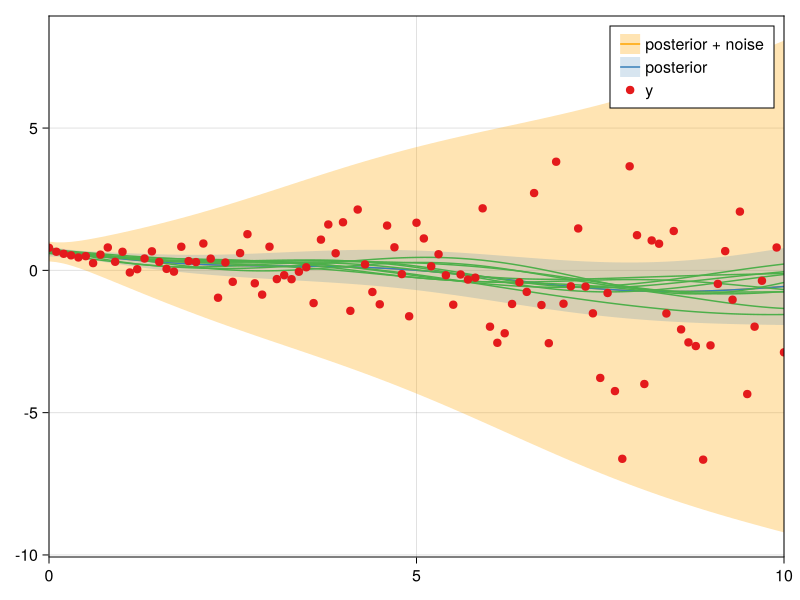

In [10]:
using CairoMakie.Makie.ColorSchemes: Set1_4

with_theme(
    Theme(;
        palette=(color=Set1_4,),
        patchcolor=(Set1_4[2], 0.2),
        Axis=(limits=((0, 10), nothing),),
    ),
) do
    plot(
        x,
        f_post(x, observation_variance(θ_final, x));
        bandscale=3,
        label="posterior + noise",
        color=(:orange, 0.3),
    )
    plot!(x, f_post; bandscale=3, label="posterior")
    gpsample!(x, f_post; samples=10, color=Set1_4[3])
    scatter!(x, y; label="y")
    axislegend()
    current_figure()
end

<hr />
<h6>Package and system information</h6>
<details>
<summary>Package information (click to expand)</summary>
<pre>
Status &#96;~/work/AbstractGPs.jl/AbstractGPs.jl/examples/3-parametric-heteroscedastic/Project.toml&#96;
  &#91;99985d1d&#93; AbstractGPs v0.5.21 &#96;/home/runner/work/AbstractGPs.jl/AbstractGPs.jl#8969233&#96;
  &#91;7834405d&#93; AbstractGPsMakie v0.2.6
⌃ &#91;13f3f980&#93; CairoMakie v0.10.12
  &#91;ec8451be&#93; KernelFunctions v0.10.63
  &#91;98b081ad&#93; Literate v2.16.1
  &#91;429524aa&#93; Optim v1.9.2
  &#91;2412ca09&#93; ParameterHandling v0.5.0
  &#91;e88e6eb3&#93; Zygote v0.6.69
  &#91;37e2e46d&#93; LinearAlgebra
  &#91;9a3f8284&#93; Random
Info Packages marked with ⌃ have new versions available and may be upgradable.
</pre>
To reproduce this notebook's package environment, you can
<a href="./Manifest.toml">
download the full Manifest.toml</a>.
</details>
<details>
<summary>System information (click to expand)</summary>
<pre>
Julia Version 1.10.2
Commit bd47eca2c8a &#40;2024-03-01 10:14 UTC&#41;
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux &#40;x86_64-linux-gnu&#41;
  CPU: 4 × AMD EPYC 7763 64-Core Processor
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 &#40;ORCJIT, znver3&#41;
Threads: 1 default, 0 interactive, 1 GC &#40;on 4 virtual cores&#41;
Environment:
  JULIA_DEBUG &#61; Documenter
  JULIA_LOAD_PATH &#61; :/home/runner/.julia/packages/JuliaGPsDocs/7M86H/src
</pre>
</details>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*